<a href="https://colab.research.google.com/github/romanfen/F21DL-G6/blob/main/Lab9_Linear_Logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

In [18]:
import sys
sys.path
from platform import python_version
assert sys.version_info >= (3, 5)
print(python_version())

import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import urllib.request
from pylab import rcParams
import seaborn as sb

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

3.7.15


# Load Data

In [19]:
# Load the data
def load_data():
    url = "https://raw.githubusercontent.com/romanfen/F21DL-G6/main/datasets/Maths.csv"
    return pd.read_csv(url)

students = load_data()
students_cols = list(students.columns)
print(students_cols)

['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


# Data Prep

In [20]:
# Make new average grade column
students['avg_grade'] = round((students['G1'] + students['G2'] + students['G3']) / 3)

In [21]:
students

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,avg_grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,6.0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,5.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,8.0
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,15.0
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,4,4,5,4,11,9,9,9,9.0
391,MS,M,17,U,LE3,T,3,1,services,services,...,4,5,3,4,2,3,14,16,16,15.0
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,3,3,3,3,3,10,8,7,8.0
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,1,3,4,5,0,11,12,10,11.0


## Binning

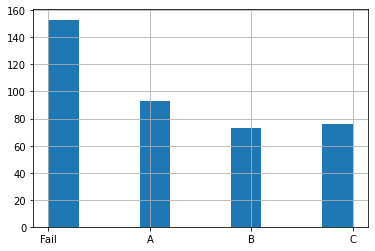

In [22]:
# Sort Grade 3 results into A,B,C and Fail Grades
# A >= 70%
# B >= 60%
# C >= 50%
# Fail < 70%

def bin_grades(dataset):
  dataset['final_grade'] = pd.cut(dataset['avg_grade'],
                            bins=[-np.inf, 9.0, 11.0, 13.0, 20],
                            labels=['Fail', 'C', 'B', 'A'])
  
bin_grades(students)
students['final_grade'].hist()

## Data Subsets

In order to find relationships between the features of our data we will split the data into smaller datasets.

activities_data - This dataset will contain infortmation relating to a students extra-cirricular activities

family_data - This dataset will contain information relating to a students family life.

school_data - This dataset will contain information relating to a students school and study habits.

personal_data - This dataset contains information relating to the invdividuals lifestyle and health

Removing the G1, G2, G3 and average grade to see the influence of other factors.

In [29]:
activities_data = students[['activities','romantic','freetime','goout','Dalc','Walc','final_grade']]
family_data = students[['famsize','Pstatus','Medu','Fedu','Mjob','Fjob','guardian','famsup','internet','final_grade']]
school_data = students[['school','studytime','failures','schoolsup','paid','nursery','higher','absences','G1','G2','G3','final_grade']]
personal_data = students[['school','sex','age','Dalc','Walc','health','absences','final_grade']]

subsets = [activities_data, family_data, school_data, personal_data]

## Training and Test Data

Split into training and test sets using following function

In [30]:
# Can also do stratified data split
from sklearn.model_selection import StratifiedShuffleSplit

def split_dataset(data, ratio):
  split = StratifiedShuffleSplit(n_splits=1, test_size=ratio, random_state=42)
  for train_index, test_index in split.split(data, data["final_grade"]):
      strat_train_set = data.loc[train_index]
      strat_test_set = data.loc[test_index]
  return strat_train_set, strat_test_set

For the current lab we want to look at the outside activity of the students to see if it can be linearly seperated. We will do a 80/20 split on training/test.

In [51]:
activities_train , activities_test = split_dataset(activities_data, 0.2)

In [52]:
activities_train

,activities,romantic,freetime,goout,Dalc,Walc,final_grade
340,yes,yes,3,4,1,3,C
219,yes,no,3,3,1,1,C
115,yes,no,4,4,1,2,A
206,no,no,3,3,2,2,Fail
46,no,no,3,5,1,4,C
...,...,...,...,...,...,...,...
337,no,yes,3,2,2,3,Fail
196,no,no,2,3,1,2,A
80,yes,yes,2,2,1,3,C
227,no,no,3,3,1,3,B


## Preprocessing

In [53]:
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

def get_types(dataset):
  num_attr = list(dataset.select_dtypes(include='number'))
  cat_attr = list(dataset.select_dtypes(exclude='number'))
  print(num_attr, cat_attr)
  return num_attr, cat_attr

num, cat = get_types(activities_train)

num_pipeline = Pipeline([
      ('MnMx_scaler', MinMaxScaler()),
  ])
cat_pipeline = OrdinalEncoder()

full_pipeline =  ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num),#  Apply the numerical transformation to the all numeric columns
        ("cat", cat_pipeline, cat), # Apply the One Hot Encoding to the all categorical columns
  ])

['freetime', 'goout', 'Dalc', 'Walc'] ['activities', 'romantic', 'final_grade']


In [54]:
activities_prep = full_pipeline.fit_transform(activities_train)

In [58]:
activities_train.head(3)

,activities,romantic,freetime,goout,Dalc,Walc,final_grade
340,yes,yes,3,4,1,3,C
219,yes,no,3,3,1,1,C
115,yes,no,4,4,1,2,A


In [81]:
activities_prep[0]

array([0.5 , 0.75, 0.  , 0.5 , 1.  , 1.  , 2.  ])

Remove the final column which correlates to final_grade

In [82]:
activities_target = activities_prep[:,6]
activities_prep = np.delete(activities_prep, np.s_[6:], 1)

# Linear Regression

In [85]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(activities_prep, activities_target)
lin_reg.intercept_ , lin_reg.coef_

(1.4952067372431035,
 array([-0.26687659,  0.33244866,  0.36138528,  0.36074293, -0.02773501,
         0.18219818]))

In [86]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(activities_prep, activities_target, rcond=1e-6)
theta_best_svd # Least-squares solution

array([1.02486977, 1.0621946 , 0.10395427, 0.59496887, 0.17382119,
       0.40445947])

In [96]:
lin_reg.score(activities_prep, activities_target)

0.04048300721326381